# Pandas Flavor

## The easy way to write your own "flavor" of Pandas.

Zach Sailer

## Here's a little teaser...

Pandas-flavor is a backward-compatible extension API for Pandas.

In [17]:
import pandas as pd

df = pd.read_csv('data/dirty-data.csv')
df.head()

,COLUMN 1,coLUMN 2,column 3,COLUMN___ 4
0,a,1,A,1
1,b,2,B,2
2,c,3,C,3


In [40]:
import re

def clean_names(df, case_type='lower'):
    """Function for cleaning column names in a pandas DataFrame.
    """
    
    def _change_case(col, case_type):
        """Change case of a column name."""
        if case_type.lower() == "upper":
            col = col.upper()
        elif case_type.lower() == "lower":
            col = col.lower()
        return col

    def _normalize(col_name):
        """Normalize common special characters."""
        result = col_name
        for search, replace in [(r"[ /:,?()\.-]", "_"), (r"['’]", "")]:
            result = re.sub(search, replace, result)
        return result

    # Should the columns be upper or lower case?
    df = df.rename(columns=lambda x: _change_case(x, case_type))

    # Normalize common special characters.
    df = df.rename(columns=_normalize)

    # Only use single underscores.
    df = df.rename(columns=lambda x: re.sub("_+", "_", x))
    
    return df

In [42]:
df = clean_names(df, case_type='lower')

## The pandas flavor way

In [40]:
import re
import pandas_flavor as pf

@pf.register_dataframe_method
def clean_names(df, case_type='lower'):
    """Function for cleaning column names in a pandas DataFrame.
    """
    def _change_case(col: str, case_type: str) -> str:
        """Change case of a column name."""
        if case_type.lower() == "upper":
            col = col.upper()
        elif case_type.lower() == "lower":
            col = col.lower()
        return col

    def _normalize(col_name: str) -> str:
        """Normalize common special characters."""
        result = col_name
        for search, replace in [(r"[ /:,?()\.-]", "_"), (r"['’]", "")]:
            result = re.sub(search, replace, result)
        return result

    # Should the columns be upper or lower case?
    df = df.rename(columns=lambda x: _change_case(x, case_type))

    # Normalize common special characters.
    df = df.rename(columns=_normalize)

    # Only use single underscores.
    df = df.rename(columns=lambda x: re.sub("_+", "_", x))
    
    return df

In [37]:
df.clean_names(case_type='upper')
df.head()

,COLUMN_1,COLUMN_2,COLUMN_3,COLUMN_4
0,a,1,A,1
1,b,2,B,2
2,c,3,C,3


Pandas-flavor enables you to easily extend the Pandas API.

## Write your own flavor of Pandas

Two ways:
* Method registration
* Accessor registration

## Part 1: Method registration

Method registration is simple. It will always follow this syntax:

In [43]:
import pandas_flavor as pf

@pf.register_dataframe_method
def my_method(df, arg1, arg2):
    print(arg1, arg2)
    return df

Your method is immediately available on the DataFrame API.

In [45]:
df = pd.DataFrame({'x': [0, 0], 'y': [1, 1]})
df.my_method('hello', 'world')

hello world


,x,y
0,0,1
1,0,1


To write your own "flavor" of Pandas, collect your custom registered functions in a Python module (or package) and import it.

In this example, I'll write my own "flavor" of Pandas called `my_flavor`.

In [47]:
import my_flavor

df = pd.DataFrame({'x': [0, 0], 'y': [1, 1]})

df.zach_func1()
df.zach_func2()

Hello, everyone!

Check out my flavor of Pandas


,x,y
0,0,1
1,0,1


A really interesting syntax sugar that emerged from Pandas-flavor is "method-chaining".

In [49]:
df = (
    pd.DataFrame({'x': [0, 0], 'y': [1, 1]})
    .zach_func1()
    .zach_func2()
)

Hello, everyone!

Check out my flavor of Pandas


This is extremely useful for "data-cleaning" activities.

## Pyjanitor

For example, a popular "flavor" in the wild is [**pyjanitor**](https://github.com/ericmjl/pyjanitor).

<img src="pyjanitor-logo.svg" width="20%">

In [68]:
df = pd.read_excel('data/dirty_data.xlsx')
df.head()

,First Name,Last Name,Employee Status,Subject,Hire Date,% Allocated,Full time?,do not edit! --->,Certification,Certification.1,Certification.2
0,Jason,Bourne,Teacher,PE,39690.0,0.75,Yes,NaN,Physical ed,Theater,NaN
1,Jason,Bourne,Teacher,Drafting,39690.0,0.25,Yes,NaN,Physical ed,Theater,NaN
2,Alicia,Keys,Teacher,Music,37118.0,1.00,Yes,NaN,Instr. music,Vocal music,NaN
3,Ada,Lovelace,Teacher,NaN,27515.0,1.00,Yes,NaN,PENDING,Computers,NaN
4,Desus,Nice,Administration,Dean,41431.0,1.00,Yes,NaN,PENDING,NaN,NaN


In [71]:
import datetime as dt 
import numpy as np

df = (
    pd.read_excel('data/dirty_data.xlsx')
    
    # Remove the empty column and empty row
    .drop("do not edit! --->", axis=1).drop(7, axis=0)
    .rename(
        mapper={
            "First Name": "first_name",
            "Last Name": "last_name",
            "Employee Status": "employee_status",
            "Subject": "subject",
            "Hire Date": "hire_date",
            "% Allocated": "percentage_allocated",
            "Full time?": "full_time",
            "Certification": "certification",
        },
        axis=1
    )
)

# Correct hire date.
df["hire_date"] = pd.TimedeltaIndex(df["hire_date"], unit="d") + dt.datetime(1899, 12, 30)

# Squash certification columns
df['certification'] = df['certification'].combine_first(df['Certification.1'])
gratitude_points = [10, 50, 20, 1000, 392, 115, 12, 182, 1190, 582, 25, 317]
df = (
    df
    .drop(["Certification.1", "Certification.2"], axis=1)
    # Add gratidude points.
    .assign(gratitude_points=gratitude_points)
)

# Log-transform gratitude points.
df["gratitude_points_log"] = df["gratitude_points"].apply(np.log10)

df.head()

,first_name,last_name,employee_status,subject,hire_date,percentage_allocated,full_time,certification,gratitude_points,gratitude_points_log
0,Jason,Bourne,Teacher,PE,2008-08-30,0.75,Yes,Physical ed,10,1.000000
1,Jason,Bourne,Teacher,Drafting,2008-08-30,0.25,Yes,Physical ed,50,1.698970
2,Alicia,Keys,Teacher,Music,2001-08-15,1.00,Yes,Instr. music,20,1.301030
3,Ada,Lovelace,Teacher,NaN,1975-05-01,1.00,Yes,PENDING,1000,3.000000
4,Desus,Nice,Administration,Dean,2013-06-06,1.00,Yes,PENDING,392,2.593286


### The pyjanitor flavor simplifies Pandas' API for data cleaning.

In [74]:
import janitor

df = (
    pd.read_excel("data/dirty_data.xlsx")
    .remove_empty()
    .clean_names(strip_underscores=True)
    .coalesce(["certification", "certification_1"])
    .convert_excel_date("hire_date")
    .rename_column("%_allocated", "percent_allocated")
    .add_column("gratitude_points", gratitude_points)
    .transform_column("gratitude_points", np.log10, "gratitude_log")
)
df.head()

,first_name,last_name,employee_status,subject,hire_date,percent_allocated,full_time,certification,gratitude_points,gratitude_log
0,Jason,Bourne,Teacher,PE,2008-08-30,0.75,Yes,Physical ed,10,1.000000
1,Jason,Bourne,Teacher,Drafting,2008-08-30,0.25,Yes,Physical ed,50,1.698970
2,Alicia,Keys,Teacher,Music,2001-08-15,1.00,Yes,Instr. music,20,1.301030
3,Ada,Lovelace,Teacher,NaN,1975-05-01,1.00,Yes,PENDING,1000,3.000000
4,Desus,Nice,Administration,Dean,2013-06-06,1.00,Yes,PENDING,392,2.593286


## Conclusion (Part 1)

Using pandas-flavor, you can write your own flavor of Pandas by **registering methods in a python module** (or package).

You can easily make your flavor pip-installable.

i.e. `pip install my_flavor`

## Part 2: Accessor registration.

An **accessor** is an *object* attached to a DataFrame that can affect (i.e. mutate) that DataFrame.

## Start with a real life use-case: PhyloPandas

In biology, we have all kinds of (non-sense) formats. For example, `fasta` is a common format for genomic sequence data. 

In [1]:
with open('data/PF08793.fasta', 'r') as f:
    print(f.read())

>Q0E553_SFAVA/184-218
KCIAFDK----ND-KINPFTGRPINENNDTYRMIYSMCHG
>Q8QUQ5_ISKNN/123-157
ACALYYD----DP-TVNPFTDEPLRRYSPIDDLLYRNCES
>Q0E553_SFAVA/142-176
YCTNFHR----DE-SRNPLTGKKLVPTSPIRKAWHKMCSG
>Q8QUQ5_ISKNN/45-79
LCAEYKR----SP-RYNPWTDRTLAPGSPKHNLISGMCGG
>Q8QUQ6_ISKNN/37-75
VCNDLALCSQHTD-TYNPWTDRALLPDSPVHDMIDYVCNT
>019R_FRG3G/249-283
VCERFAA----DP-TRNPVTGSPLSRNDPLYTDLMEICKG
>019R_FRG3G/302-336
TCEAFCR----DP-TRNPVTGQKMRRNGIEYQMFAEECDC
>VF380_IIV6/7-45
KCDEWEKIRLNSS-PKNPFTKRNVKKDGPTYKKIDLICKH
>VF380_IIV3/8-47
KCYEWDIAKKKSPLPKSPLTGRKLKQHGPTWKKITAECAT
>VF378_IIV6/4-38
KCSKWHE----QP-LINPLTNRKIKKNGPTYKELERECGP
>O41158_PBCV1/63-96
LCSKWKA----NP-LVNPATGRKIKKDGPVYEKIQKKCS-
>019R_FRG3G/5-39
YCDEFER----NP-TRNPRTGRTIKRGGPVFRALERECSD
>019R_FRG3G/139-172
-CPEFAR----DP-TRNPRTGRTIKRGGPTYRALEAECAD
>VF232_IIV6/64-98
ECEQWLA----NK-GINPRTGKAIKIGGPTYKKLEMECKE
>Q0E553_SFAVA/60-94
VCKKFLA----NK-TVSPYSGRPIKPGKKLYNDLEKHCSG
>Q8QUQ5_ISKNN/164-198
QCRAFEE----NP-DVNPNTGRRISPTGPIASSMRRRCMN
>Q8QUQ5_ISKNN/7-42
KCNQLRN----

I started by writing my own `read_` functions.

In [1]:
import phylopandas as ph

df = ph.read_fasta('data/PF08793.fasta')
df.head()

,id,sequence,description,label,uid
0,Q0E553_SFAVA/184-218,KCIAFDK----ND-KINPFTGRPINENNDTYRMIYSMCHG,Q0E553_SFAVA/184-218,Q0E553_SFAVA/184-218,pcU81Urx20
1,Q8QUQ5_ISKNN/123-157,ACALYYD----DP-TVNPFTDEPLRRYSPIDDLLYRNCES,Q8QUQ5_ISKNN/123-157,Q8QUQ5_ISKNN/123-157,DZIedQvu4D
2,Q0E553_SFAVA/142-176,YCTNFHR----DE-SRNPLTGKKLVPTSPIRKAWHKMCSG,Q0E553_SFAVA/142-176,Q0E553_SFAVA/142-176,7uixV5MipM
3,Q8QUQ5_ISKNN/45-79,LCAEYKR----SP-RYNPWTDRTLAPGSPKHNLISGMCGG,Q8QUQ5_ISKNN/45-79,Q8QUQ5_ISKNN/45-79,bPdJq9TB4B
4,Q8QUQ6_ISKNN/37-75,VCNDLALCSQHTD-TYNPWTDRALLPDSPVHDMIDYVCNT,Q8QUQ6_ISKNN/37-75,Q8QUQ6_ISKNN/37-75,d26jKIgCF9


But I couldn't write that DataFrame back out to biological data formats.

So I wrote an *accessor* with custom write methods. 

In [2]:
print(df.phylo.to_fasta(id_col='label'))

>Q0E553_SFAVA/184-218
KCIAFDK----ND-KINPFTGRPINENNDTYRMIYSMCHG
>Q8QUQ5_ISKNN/123-157
ACALYYD----DP-TVNPFTDEPLRRYSPIDDLLYRNCES
>Q0E553_SFAVA/142-176
YCTNFHR----DE-SRNPLTGKKLVPTSPIRKAWHKMCSG
>Q8QUQ5_ISKNN/45-79
LCAEYKR----SP-RYNPWTDRTLAPGSPKHNLISGMCGG
>Q8QUQ6_ISKNN/37-75
VCNDLALCSQHTD-TYNPWTDRALLPDSPVHDMIDYVCNT
>019R_FRG3G/249-283
VCERFAA----DP-TRNPVTGSPLSRNDPLYTDLMEICKG
>019R_FRG3G/302-336
TCEAFCR----DP-TRNPVTGQKMRRNGIEYQMFAEECDC
>VF380_IIV6/7-45
KCDEWEKIRLNSS-PKNPFTKRNVKKDGPTYKKIDLICKH
>VF380_IIV3/8-47
KCYEWDIAKKKSPLPKSPLTGRKLKQHGPTWKKITAECAT
>VF378_IIV6/4-38
KCSKWHE----QP-LINPLTNRKIKKNGPTYKELERECGP
>O41158_PBCV1/63-96
LCSKWKA----NP-LVNPATGRKIKKDGPVYEKIQKKCS-
>019R_FRG3G/5-39
YCDEFER----NP-TRNPRTGRTIKRGGPVFRALERECSD
>019R_FRG3G/139-172
-CPEFAR----DP-TRNPRTGRTIKRGGPTYRALEAECAD
>VF232_IIV6/64-98
ECEQWLA----NK-GINPRTGKAIKIGGPTYKKLEMECKE
>Q0E553_SFAVA/60-94
VCKKFLA----NK-TVSPYSGRPIKPGKKLYNDLEKHCSG
>Q8QUQ5_ISKNN/164-198
QCRAFEE----NP-DVNPNTGRRISPTGPIASSMRRRCMN
>Q8QUQ5_ISKNN/7-42
KCNQLRN----

The PhyloPandas flavor registers a `phylo` accessor on Pandas' DataFrame that include custom functions for biological data.

In [3]:
accessor = df.phylo

for item in dir(accessor):
    if item[:2] == 'to':
        print(item)

to_clustal
to_dendropy
to_embl
to_fasta
to_fasta_twoline
to_fastq
to_newick
to_nexus_seq
to_nexus_tree
to_phylip
to_phylip_relaxed
to_phylip_sequential
to_swiss


Combining representations of data into a single DataFrame.

In [4]:
with open('data/PF08793.newick', 'r') as f:
    print(f.read())

(Q8QUQ5_ISKNN/45-79:0.38376442,Q8QUQ6_ISKNN/37-75:0.93473288,(Q8QUQ5_ISKNN/123-157:1.14582942,(Q0E553_SFAVA/142-176:0.94308689,(Q0E553_SFAVA/184-218:0.98977147,(Q0E553_SFAVA/60-94:0.95706148,(((019R_FRG3G/5-39:0.06723315,(019R_FRG3G/139-172:0.05690376,(019R_FRG3G/249-283:0.95772959,019R_FRG3G/302-336:0.58361302)2.745285:0.61968795)1.680162:0.12814819)8.545520:0.30724093,((VF232_IIV6/64-98:0.77338949,((VF380_IIV6/7-45:0.56133629,VF380_IIV3/8-47:0.64307079)7.484104:0.37367018,(VF378_IIV6/4-38:0.31530205,O41158_PBCV1/63-96:0.46076842)1.909391:0.20522645)0.218717:0.09388521)2.531435:0.20551347,Q0E553_SFAVA/14-48:1.58834786)0.265099:0.00027193)6.209727:0.37908212,(Q8QUQ5_ISKNN/164-198:0.63907222,Q8QUQ5_ISKNN/7-42:0.96743219)2.806276:0.362965)0.677978:0.20054193)0.718698:0.20642561)2.503850:0.27168922)1.162623:0.15868612)6.040602:0.48939921);



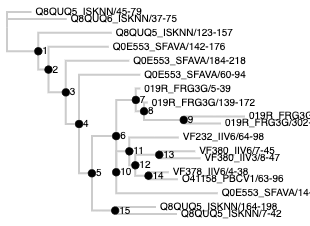

In [5]:
from phylovega import TreeChart

TreeChart.from_newick('data/PF08793.newick')

The PhyloPandas flavor has some clever logic to merge two data formats in a single DataFrame.

In [8]:
df = df.phylo.read_newick('data/PF08793.newick', combine_on='id')
df.head()

,id,sequence,description,label,uid,type,parent,length,distance
0,Q0E553_SFAVA/184-218,KCIAFDK----ND-KINPFTGRPINENNDTYRMIYSMCHG,Q0E553_SFAVA/184-218,Q0E553_SFAVA/184-218,TtW1BnkTvj,leaf,3,0.989771,1.90955
1,Q8QUQ5_ISKNN/123-157,ACALYYD----DP-TVNPFTDEPLRRYSPIDDLLYRNCES,Q8QUQ5_ISKNN/123-157,Q8QUQ5_ISKNN/123-157,q3Hl8FAZGA,leaf,1,1.14583,1.63523
2,Q0E553_SFAVA/142-176,YCTNFHR----DE-SRNPLTGKKLVPTSPIRKAWHKMCSG,Q0E553_SFAVA/142-176,Q0E553_SFAVA/142-176,Cn42aDD8NC,leaf,2,0.943087,1.59117
3,Q8QUQ5_ISKNN/45-79,LCAEYKR----SP-RYNPWTDRTLAPGSPKHNLISGMCGG,Q8QUQ5_ISKNN/45-79,Q8QUQ5_ISKNN/45-79,5T3jZDdx34,leaf,0,0.383764,0.383764
4,Q8QUQ6_ISKNN/37-75,VCNDLALCSQHTD-TYNPWTDRALLPDSPVHDMIDYVCNT,Q8QUQ6_ISKNN/37-75,Q8QUQ6_ISKNN/37-75,XukasPxu5F,leaf,0,0.934733,0.934733


Don't forget, we still get all of Pandas!

In [12]:
df[df.length > 0.8]

,id,sequence,description,label,uid,type,parent,length,distance
0,Q0E553_SFAVA/184-218,KCIAFDK----ND-KINPFTGRPINENNDTYRMIYSMCHG,Q0E553_SFAVA/184-218,Q0E553_SFAVA/184-218,TtW1BnkTvj,leaf,3,0.989771,1.90955
1,Q8QUQ5_ISKNN/123-157,ACALYYD----DP-TVNPFTDEPLRRYSPIDDLLYRNCES,Q8QUQ5_ISKNN/123-157,Q8QUQ5_ISKNN/123-157,q3Hl8FAZGA,leaf,1,1.14583,1.63523
2,Q0E553_SFAVA/142-176,YCTNFHR----DE-SRNPLTGKKLVPTSPIRKAWHKMCSG,Q0E553_SFAVA/142-176,Q0E553_SFAVA/142-176,Cn42aDD8NC,leaf,2,0.943087,1.59117
4,Q8QUQ6_ISKNN/37-75,VCNDLALCSQHTD-TYNPWTDRALLPDSPVHDMIDYVCNT,Q8QUQ6_ISKNN/37-75,Q8QUQ6_ISKNN/37-75,XukasPxu5F,leaf,0,0.934733,0.934733
5,019R_FRG3G/249-283,VCERFAA----DP-TRNPVTGSPLSRNDPLYTDLMEICKG,019R_FRG3G/249-283,019R_FRG3G/249-283,IZv73osVf3,leaf,9,0.95773,3.71863
14,Q0E553_SFAVA/60-94,VCKKFLA----NK-TVSPYSGRPIKPGKKLYNDLEKHCSG,Q0E553_SFAVA/60-94,Q0E553_SFAVA/60-94,W1G9zOfUXZ,leaf,4,0.957061,2.08326
16,Q8QUQ5_ISKNN/7-42,KCNQLRN----NRYTVNPVSNRAIAPRGDTANTLRRICEQ,Q8QUQ5_ISKNN/7-42,Q8QUQ5_ISKNN/7-42,NfPy0twmjS,leaf,15,0.967432,2.65714
17,Q0E553_SFAVA/14-48,QCETFKR----NKQAVSPLTNCPIDKFGRTAARFRKECD-,Q0E553_SFAVA/14-48,Q0E553_SFAVA/14-48,EzDPOT93RZ,leaf,10,1.58835,3.29444


And just for fun, we added a simple `.display` method for showing the data.

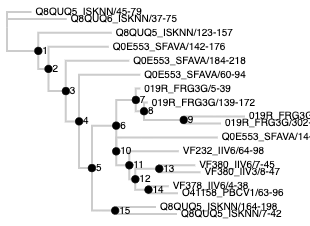

In [7]:
df.phylo.display()

In this approach, we flavor Pandas by containing all our custom functions in an accessor. 

## How do we write an accessor?

Checkout the `my_flavor_accessor.py` module.

In [20]:
import my_flavor_accessor

df = pd.DataFrame({'x': [0, 0], 'y': [1, 1]})

df.zach.func1()
df.zach.func2()

Hello, everyone!

Check out my flavor of Pandas


,x,y
0,0,1
1,0,1


## Conclusion (Part 2): What does this mean for you?

* We (the scientific community) can write domain-specific DataFrames.

        Follow our example in the evolutionary biology community.

* DataFrames encourage "data scientists" to define schemas or grammars (standardized column names) for their domain.

        Pandas Flavor makes it easy to build a domain-specific API for those schemas.

## Other Pandas flavors in the wild...

* pandas `.plot`
* pdvega
* pyjanitor
* geopandas
* python-ctd
* pingouin

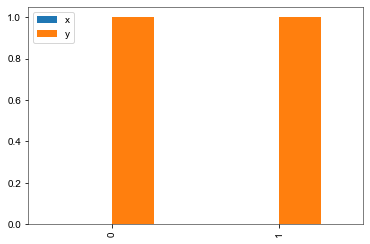

In [19]:
%matplotlib inline

df.plot.bar()

## Acknowledgements

* Eric Ma (creator of pyjanitor)
* BioPython community (for PhyloPandas inspiration)
* Jeet Sukumaran (creator of DendroPy)
* Jake Vanderplas (original review of pandas-flavor)
* Mike Harms (graduate PI and contributor to phylopandas)

Thanks!